# Анализ графа взаимодействия сотрудников офиса

<div class='alert alert-block alert-info'>
    <p><b>О наборе данных:</b>Зафиксированные контакты сотрудников французского офиса на рабочих местах. Каждая запись содержит время контакта и безличные идентификаторы двух сотрудников. Контакты фиксировались в 20-секундных интервалах.</p>
    <p><a href='http://www.sociopatterns.org/datasets/test/'>Источник.</a></p>
    <p><a href='http://www.sociopatterns.org/publications/can-co-location-be-used-as-a-proxy-for-face-to-face-contacts/'>Публикация.</a></p>
</div>

<div class='alert alert-block alert-warning'>
    <p><b>Цель: </b>Вычисление основнгых метрик ненаправленного графа. Анализ взаимодействия сотрудников разных отделов, выявление влиятельных групп и персон.</p>    
</div>

1. <a href='#1'>Анализ и подготовка данных</a>  
    1.1 <a href='#11'>Чтение данных из файла</a>      
    1.2 <a href='#12'>Подготовка данных</a>  
    1.3 <a href='#13'>Построенеие графа сети взаимодействия</a>
2. <a href='#20'>Вычисление и визуализация метрик графа</a>  
    2.1 <a href='#21'>Степени вершин</a>  
    2.2 <a href='#22'>Индексы центральности</a>  
    2.3 <a href='#23'>Визуализаця метрик</a>      
3. <a href='#30'>Поиск циклов графа и клик</a>

## <a id='1'>1. Анализ и подготовка данных</a>

### <a id='11'>1.1 Чтение данных из файла</a>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
data_file_name = './data/tij_InVS15.csv'

In [3]:
raw_data_frame = pd.read_csv(data_file_name, sep= ' ', names=['t', 'i', 'j'])

In [4]:
raw_data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78249 entries, 0 to 78248
Data columns (total 3 columns):
t    78249 non-null int64
i    78249 non-null int64
j    78249 non-null int64
dtypes: int64(3)
memory usage: 1.8 MB


In [5]:
raw_data_frame

,t,i,j
0,28840,574,1362
1,28840,164,779
2,28860,447,763
3,28860,117,429
4,28880,447,763
...,...,...,...
78244,1022360,322,634
78245,1022380,1067,1342
78246,1022380,387,426
78247,1022380,18,650


#### Исходный файл содержит записи вида [временная отметка] [id сотрудника A] [id сотрудника B]

In [6]:
import matplotlib.colors as colors

In [7]:
meta_file_name = './data/metadata_InVS15.csv'

In [8]:
meta_data_frame = pd.read_csv(meta_file_name, sep='\t', header=None)
meta_data_frame.columns = ['id', 'dep']
meta_data_frame.set_index('id', drop=True, inplace=True)

In [9]:
meta_data_frame

,dep
id,
20,DCAR
89,DCAR
97,DCAR
118,DCAR
132,DCAR
...,...
628,SSI
847,SSI
970,SSI


#### Кроме того, имеется информация о принадлежности сотрудников к отделам (департаментам)

In [10]:
meta_data_frame['dep'].value_counts()

DMI     60
DSE     34
DMCT    33
DST     24
DISQ    18
SFLE    17
DCAR    15
SSI      9
SRH      9
SCOM     7
SDOC     4
DG       2
Name: dep, dtype: int64

In [11]:
meta_data_frame['dep'].unique()

array(['DCAR', 'DG', 'DISQ', 'DMCT', 'DMI', 'DSE', 'DST', 'SCOM', 'SDOC',
       'SFLE', 'SRH', 'SSI'], dtype=object)

In [12]:
dep_color_dict = {
    'DCAR': 'darkorange', 'DG': 'darkseagreen',
    'DISQ': 'firebrick', 'DMCT': 'lightblue',
    'DMI': 'gold', 'DSE': 'lawngreen',
    'DST': 'tan', 'SCOM': 'orchid',
    'SDOC': 'darkcyan', 'SFLE': 'lightcoral',
    'SRH': 'yellow', 'SSI': 'lightsteelblue'
}

#### Информацию о принадлежности к департаметнту будем использовать при визуализации: __цвет узла__ графа будет обозначать __департамент__, к которому относится сотрудник.

In [13]:
user_colors_dict = {user_id: dep_color_dict[meta_data_frame.loc[user_id]['dep']] for user_id in meta_data_frame.index }

### <a id='12'>1.2 Подготовка данных</a>

#### Для построения графа сети взаимодействия сортрудников нужно построить список рёбер графа.

<div class='alert alert-block alert-warning'>
    <h4>Граф сети взаимодействия, который мы хотим построить будет описывать связи между сотрудниками.</h3>
    <h4>Узлы графа будут обозначать сотрудников, рёбра - зафиксированные контакты, вес рёбер - "устойчивость" или "интенсивность" сязей между сотрудниками.</h4>
</div>

#### Исходные данные содержат сведения о зафиксированных контактах в 20-секундных интервалах на протяжении 18-ти рабочих дней.
#### Такая инфорнмация позволяет отследить развитие сети взаимодействия во времени.
#### Однако, нас будет интересовать наличие устойчивых связей между сотрудниками.
#### Поэтому мы для каждой пары взимодействующих сотрудников вычислим __суммарное__ количество контактов за весь период наблюдений.

In [14]:
contact_counts = raw_data_frame.groupby(by=['i', 'j']).count()
contact_counts.columns=['count']

In [15]:
contact_counts

count
i    j          
1    117       1
3    15        1
     20        2
     55        1
     74        1
...          ...
1342 1362      2
1362 1392     27
     1485      1
     1492      3
1414 1492      1

[4274 rows x 1 columns]

In [16]:
edge_list_df = pd.DataFrame(contact_counts.index.to_flat_index())
edge_list_df.columns = ['A-B']
edge_list_df['A'] = edge_list_df['A-B'].apply(lambda x: x[0])
edge_list_df['B'] = edge_list_df['A-B'].apply(lambda x: x[1])
edge_list_df['count'] = contact_counts['count'].values
edge_list_df.drop(['A-B'], axis=1, inplace=True)
edge_list_df.sort_values(by=['A', 'B'], inplace=True, ascending=True)
edge_list_df.reset_index(drop=True, inplace=True)

#### Так выглядит список рёбер нашего будущего графа: A и B - id участников взаимодействия, count - общее количество их взаимодействий за 18 дней.

<div class='alert alert-block alert-warning'>
    <h4>Мы строим ненаправленный граф - фиксируется сам факт взаимодействия, о его направленности информации нет.</h4>
</div>

In [17]:
edge_list_df

,A,B,count
0,1,117,1
1,3,15,1
2,3,20,2
3,3,55,1
4,3,74,1
...,...,...,...
4269,1342,1362,2
4270,1362,1392,27
4271,1362,1485,1
4272,1362,1492,3


#### Для каждого сотрудника уже можно подсчитать общее суммарное количество зафиксированных контактов и составить рейтинг сотрудников с наиболее устойчивыми взаимодействиями.
#### Поскольку id каждого пользователя может фигурировать в списке рёбер на обеих их вершинах, для каждого id нужно просуммировать количество взаимодействий в обоих случаях.

In [18]:
target_cum_counts = edge_list_df.groupby('B', sort=False).sum().drop('A', axis=1)
target_cum_counts.index.rename('id', inplace=True)
source_cum_counts = edge_list_df.groupby('A', sort=False).sum().drop('B', axis=1)
source_cum_counts.index.rename('id', inplace=True)

In [19]:
nodes_cum_counts = pd.merge(target_cum_counts, source_cum_counts, how='outer', left_index=True, right_index=True).fillna(0)
nodes_cum_counts['cum_count'] = nodes_cum_counts['count_x'] + nodes_cum_counts['count_y']
nodes_cum_counts = nodes_cum_counts.drop(['count_x', 'count_y'], axis=1)
nodes_cum_counts

,cum_count
id,
1,1.0
3,452.0
14,379.0
15,705.0
18,1143.0
...,...
1362,477.0
1392,1329.0
1414,476.0


In [20]:
user_summary_df = nodes_cum_counts.copy(deep=True)
user_summary_df['dep'] = [meta_data_frame.loc[user_id]['dep'] for user_id in user_summary_df.index]
user_summary_df['dep_color'] = user_summary_df['dep'].apply(lambda x: dep_color_dict[x])

#### Создадим таблицу, в которую будем собирать все метрики графа.

In [21]:
user_summary_df

,cum_count,dep,dep_color
id,,,
1,1.0,SFLE,lightcoral
3,452.0,DMI,gold
14,379.0,SCOM,orchid
15,705.0,DMI,gold
18,1143.0,SRH,yellow
...,...,...,...
1362,477.0,DST,tan
1392,1329.0,DST,tan
1414,476.0,SFLE,lightcoral


### <a id='13'>1.3 Построение графа сети взаимодействий</a>

In [22]:
import networkx as nx

In [23]:
nx_graph = nx.from_pandas_edgelist(edge_list_df, source='A', target='B', edge_attr='count')

#### Из списка рёбер создали объект networkx.Graph.

In [24]:
print(nx.info(nx_graph))

Name: 
Type: Graph
Number of nodes: 217
Number of edges: 4274
Average degree:  39.3917


#### Граф состоит из 217-ти узлов и 4274-ёх рёбер.

## <a id='20'>2. Вычисление и визуализация метрик графа</a>

### <a id='21'>2.1 Степени вершин</a>

#### Степень (degree) вершины графа - количество рёбер, изходящих из неё.
#### В нашем случае - это количество коллег, с которыми контактировал сотрудник.

In [25]:
unweighted_degree = pd.DataFrame.from_dict(dict(nx.degree(nx_graph)), orient='index', columns=['degree']).sort_index()
user_summary_df['degree'] = unweighted_degree['degree']

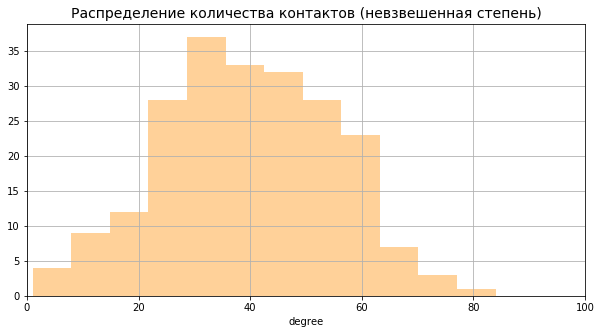

In [26]:
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(user_summary_df['degree'], ax=ax, color='darkorange', kde=False)
ax.grid()
ax.set_xlim(0, 100);
ax.set_title('Распределение количества контактов (невзвешенная степень)', fontsize=14);

In [27]:
user_summary_df['degree'].describe()

count    217.000000
mean      39.391705
std       15.613341
min        1.000000
25%       29.000000
50%       39.000000
75%       51.000000
max       84.000000
Name: degree, dtype: float64

#### Можно сказать, что в исследовании участвовал довольно сплочённый коллектив.
#### В среднем, каждый сотрудник контактировал с 39-ью коллегами из 217-ти - это почти 20%, т.е каждый пятый.

#### В терминах теории графов суммарное количество взаимодействий каждого пользователей - это сумма весов всех рёбер, исходящих из вершины.
#### Эта метрика называется взвешенная степень - weighted degree, strength.

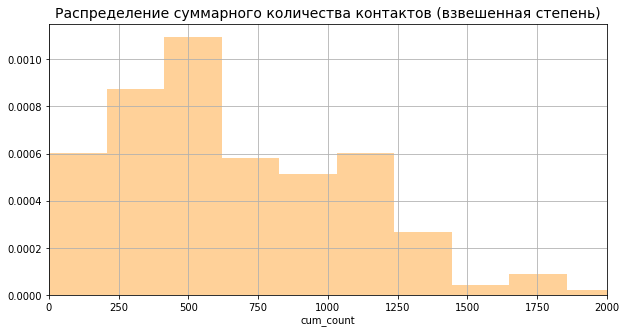

In [28]:
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(user_summary_df['cum_count'], ax=ax, color='darkorange', kde=False, norm_hist=True)
ax.grid()
ax.set_xlim(0, 2000);
ax.set_title('Распределение суммарного количества контактов (взвешенная степень)', fontsize=14);

In [29]:
user_summary_df['cum_count'].describe()

count     217.000000
mean      721.188940
std       515.877719
min         1.000000
25%       356.000000
50%       588.000000
75%      1007.000000
max      3301.000000
Name: cum_count, dtype: float64

#### Разброс суммарного количества контактов намного больше, чем разброс количества коллег, с которыми контактируют сотрудники.
#### Действительно, активность общения людей различна: даже при одном и том же количестве коллег, с которыми сотрудники общаются в рабочее время,
#### у разных пар сотрудников может быть разное количество общих тем и вопросов.

### <a id='22'>2.2 Индексы центральности</a>

In [30]:
betweenness_centrality = pd.DataFrame.from_dict(nx.betweenness_centrality(nx_graph), orient='index', columns=['betw_cent']).sort_index()
user_summary_df['betw_cent'] = betweenness_centrality['betw_cent']

#### Применительно с графу взаимодействия сотрудников, степень посредничества вершины (сотрудника) показывает, какова вероятность того, что два других сотрудника связаны через этого.
#### Высокое значение степени посредничества в коллективе означает централизацию взаимодействий, наличие строгой субординации, когда, например, подчинённые из разных отделов
#### через руководителей.
#### Низкие значения этой метрики свидетельствуют о, скорее, гибком, неформальном и менее централизованном стиле взаимодействия.

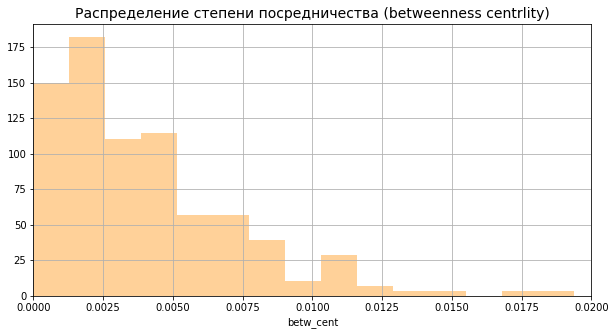

In [31]:
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(betweenness_centrality['betw_cent'], ax=ax, color='darkorange', kde=False, norm_hist=True)
ax.grid()
ax.set_xlim(0, 0.02);
ax.set_title('Распределение степени посредничества (betweenness centrlity)', fontsize=14);

#### В данном случае выводы делать сложно: разброс значений велик, т.е. сложно говорить о преобладании какого-то диапазона значений,
#### кроме того, хараткер взаимодействия сотрудников нам не известен, контакты личные и служебные перемешаны.
#### Но, в целом, можно судить о низкой степени централизации взаимодействий, отсутствии ограничениий и вообще регулирования взаимодействий.

In [32]:
eigenvector_centrality = pd.DataFrame.from_dict(nx.eigenvector_centrality(nx_graph), orient='index', columns=['eigenv_cent']).sort_index()
user_summary_df['eigenv_cent'] = eigenvector_centrality['eigenv_cent']

#### Степень влиятельности - в нашем случае, показатель того, как много сотрудник имеет контактов, в свою очередь, имеющих много контактов.

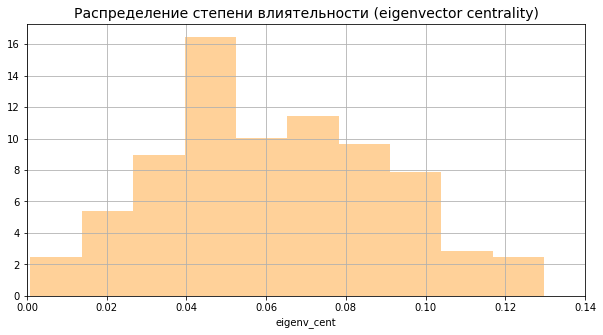

In [33]:
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(eigenvector_centrality['eigenv_cent'], ax=ax, color='darkorange', kde=False, norm_hist=True)
ax.grid()
ax.set_xlim(0, 0.14);
ax.set_title('Распределение степени влиятельности (eigenvector centrality)', fontsize=14);

In [34]:
user_summary_df['eigenv_cent'].describe()

count    217.000000
mean       0.061903
std        0.027926
min        0.000890
25%        0.040721
50%        0.059715
75%        0.082390
max        0.129757
Name: eigenv_cent, dtype: float64

#### Разброс значений степени влияетльности велик.
#### Это согласуется с распределением количества коллег, с которыми контактируют сотрудники:
#### общение не регулируется, можно сказать, все общаются со всеми, поэтому нет чёткого разделения на влиятельных и невлиятельных сотрудников.

In [35]:
closeness_centrality =  pd.DataFrame.from_dict(nx.closeness_centrality(nx_graph), orient='index', columns=['close_cent']).sort_index()
user_summary_df['close_cent'] = closeness_centrality['close_cent']

#### Степень близости - показатель того, напрямую ли взаимодействуют сотрудники, насколько вершины графа близки друг к другу.

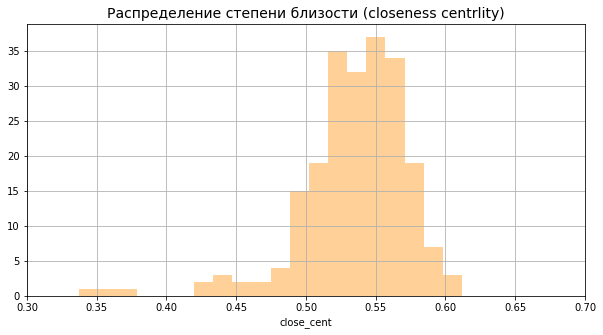

In [36]:
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(closeness_centrality['close_cent'], ax=ax, color='darkorange', kde=False)
ax.grid()
ax.set_xlim(0.3, 0.7);
ax.set_title('Распределение степени близости (closeness centrlity)', fontsize=14);

In [37]:
user_summary_df['close_cent'].describe()

count    217.000000
mean       0.534586
std        0.038923
min        0.337500
25%        0.517986
50%        0.538653
75%        0.559585
max        0.611898
Name: close_cent, dtype: float64

#### Среднее значение степени близости близко к максимальному, дисперсия - менее 10% от среднего.
#### Эти показатели потдтверждают выводы о том, что в исследуемом коллективе развиты связи между всеми сотрудниками,
#### и их общение не подвергается ограничениям.

### <a id='23'>2.3 Визуализация метрик</a>

#### Для наглядного отображения вычисленных метрик, используем изображения графа взаимодействи, меняя параметры визуализации.
#### Толщина рёбер обозначает интенсивность (усойчивость) контактов сотрудников.
#### Цвет вершин - принадлежность к тому или иному департаменту.
#### А размер вершин будем менять в зависимости от значений выбранной метрики.

In [38]:
node_positions = nx.kamada_kawai_layout(nx_graph)

#### Зафиксируем взаимное расположение вершин на визуализациях.

C:\Users\Supervisor\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


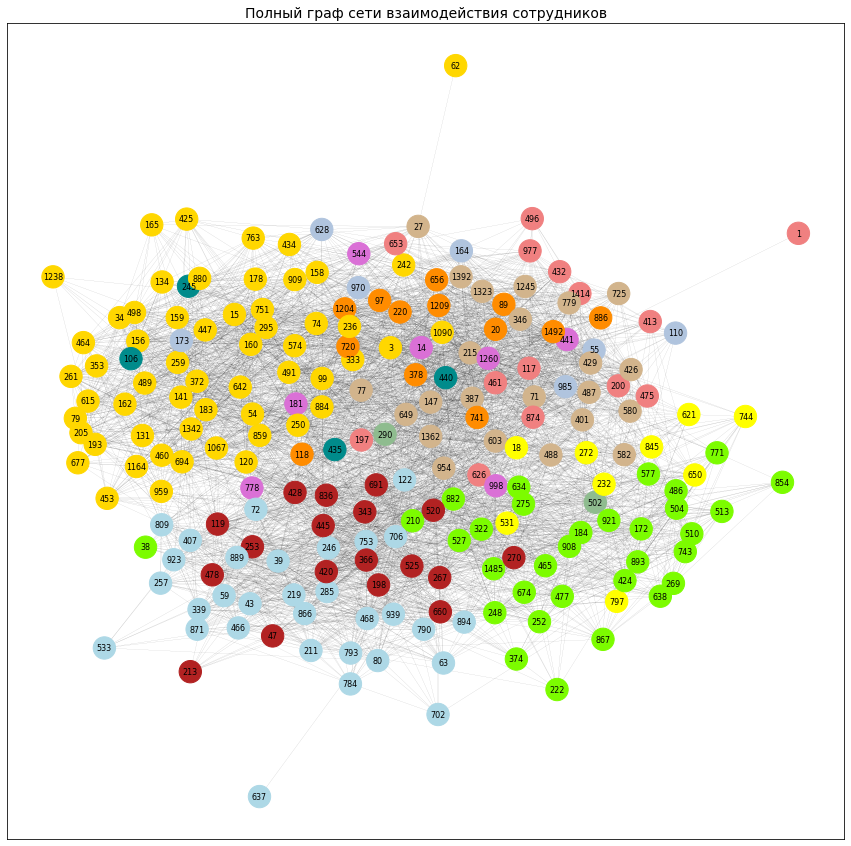

In [39]:
fig, ax = plt.subplots(figsize=(15,15))
nx.draw_networkx(
    nx_graph, ax=ax,
    node_size=500,
    node_color=user_summary_df.loc[list(nx_graph.nodes)]['dep_color'],
    pos=node_positions, width=0.05,
    font_size=8
)
ax.set_title('Полный граф сети взаимодействия сотрудников', fontsize=14);

In [40]:
activity_rating = user_summary_df.sort_values(by='cum_count', ascending=False)
most_active_list = activity_rating.index.tolist()[:50]
centrality_rating = user_summary_df.sort_values(by='betw_cent', ascending=False)
most_important_list = centrality_rating.index.tolist()[:50]
influence_rating = user_summary_df.sort_values(by='eigenv_cent', ascending=False)
most_influencing_list = influence_rating.index.tolist()[:50]
closeness_rating = user_summary_df.sort_values(by='close_cent', ascending=False)
most_reachable_list = closeness_rating.index.tolist()[:50]

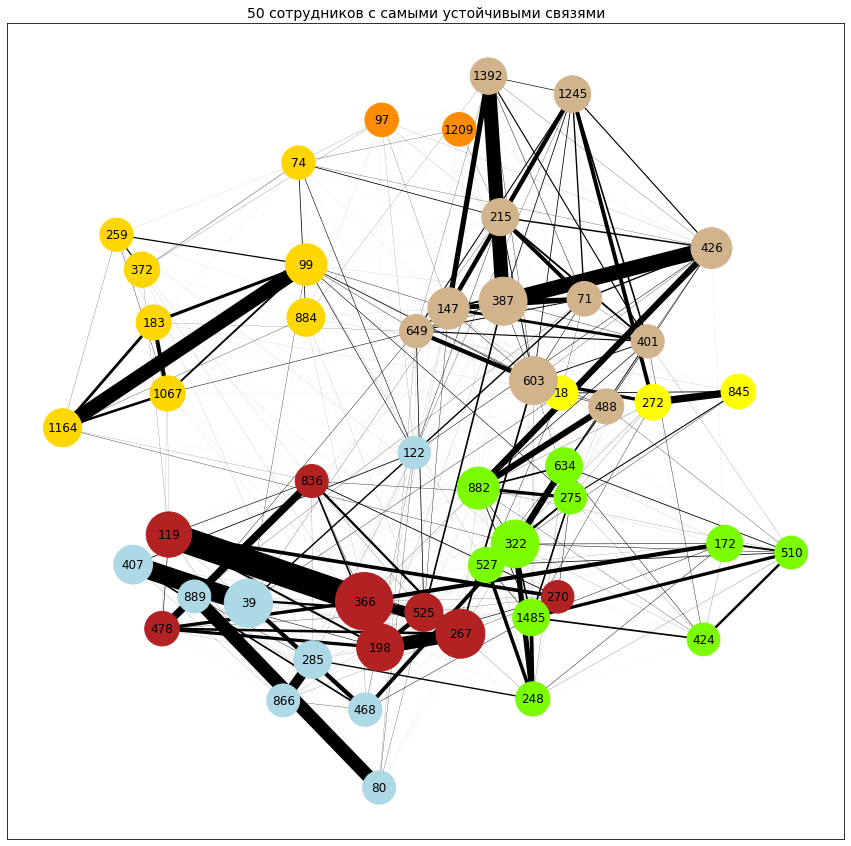

In [41]:
fig, ax = plt.subplots(figsize=(15,15))
subgraph=nx.subgraph(nx_graph, nbunch=most_active_list)
edge_width = [0.02 * nx_graph[u][v]['count'] for u, v in subgraph.edges()]
nx.draw_networkx(
    subgraph, ax=ax,
    node_size=activity_rating.loc[list(subgraph.nodes)]['cum_count'],
    node_color=activity_rating.loc[list(subgraph.nodes)]['dep_color'],
    width=edge_width,
    pos=node_positions
)
ax.set_title('50 сотрудников с самыми устойчивыми связями', fontsize=14);

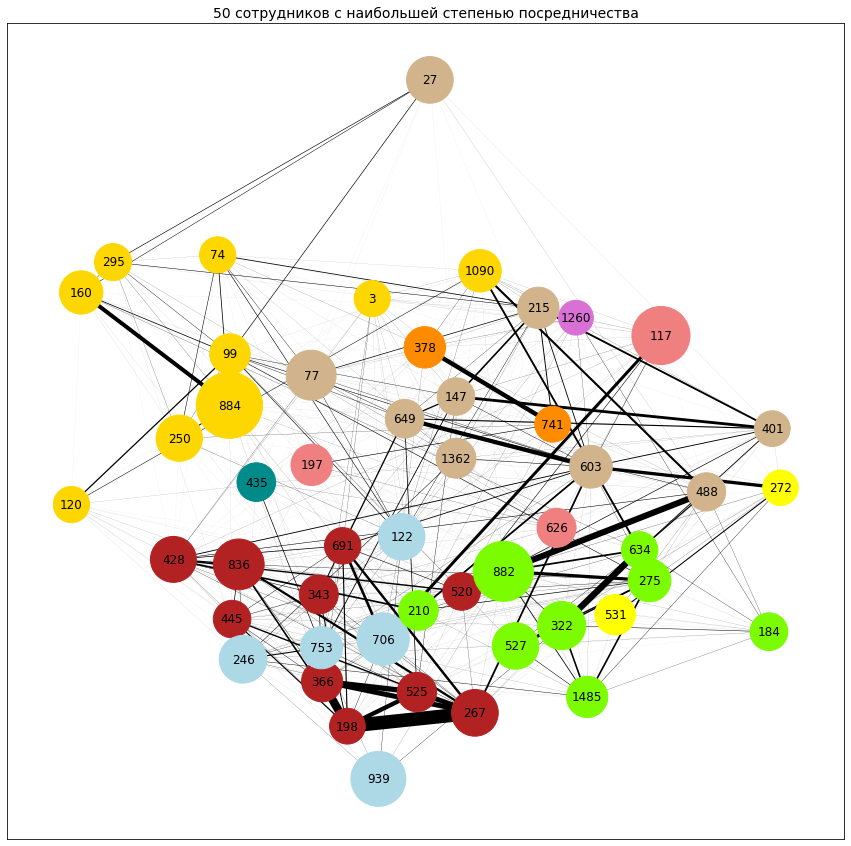

In [42]:
fig, ax = plt.subplots(figsize=(15,15))
subgraph=nx.subgraph(nx_graph, nbunch=most_important_list)
edge_width = [0.02 * nx_graph[u][v]['count'] for u, v in subgraph.edges()]
nx.draw_networkx(
    subgraph, ax=ax,
    node_size=centrality_rating.loc[list(subgraph.nodes)]['betw_cent']*2e5,
    node_color=centrality_rating.loc[list(subgraph.nodes)]['dep_color'],
    pos=node_positions, width=edge_width
)
ax.set_title('50 сотрудников с наибольшей степенью посредничества', fontsize=14);

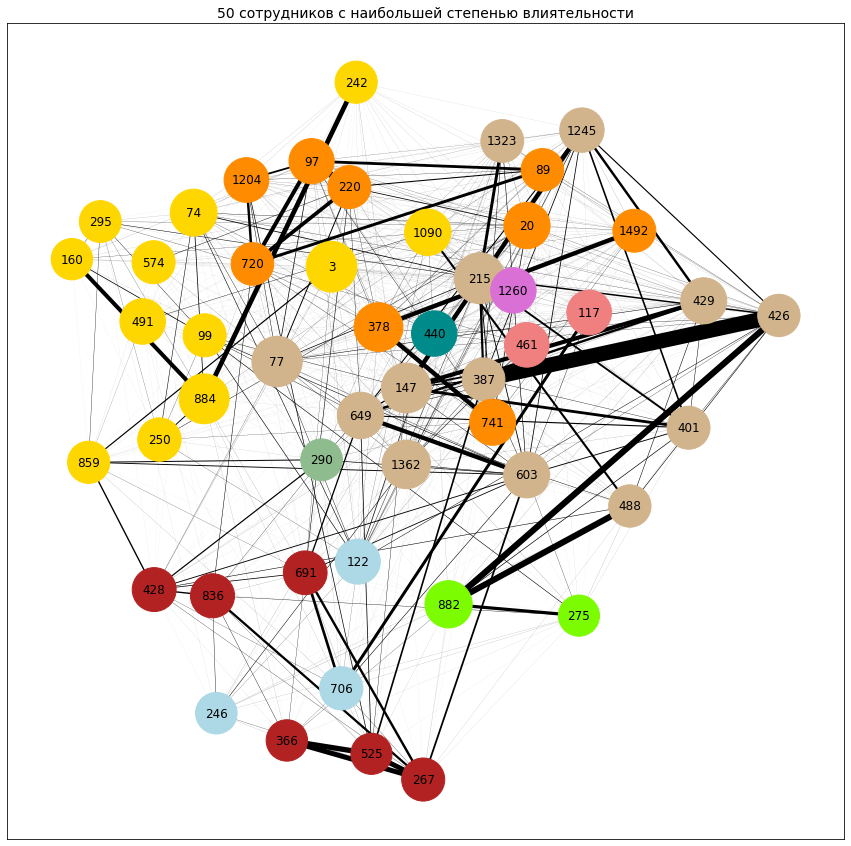

In [43]:
fig, ax = plt.subplots(figsize=(15,15))
subgraph=nx.subgraph(nx_graph, nbunch=most_influencing_list)
edge_width = [0.02 * nx_graph[u][v]['count'] for u, v in subgraph.edges()]
nx.draw_networkx(
    subgraph, ax=ax,
    node_size=influence_rating.loc[list(subgraph.nodes)]['eigenv_cent']*2e4,
    node_color=influence_rating.loc[list(subgraph.nodes)]['dep_color'],
    pos=node_positions, width=edge_width
)
ax.set_title('50 сотрудников с наибольшей степенью влиятельности', fontsize=14);

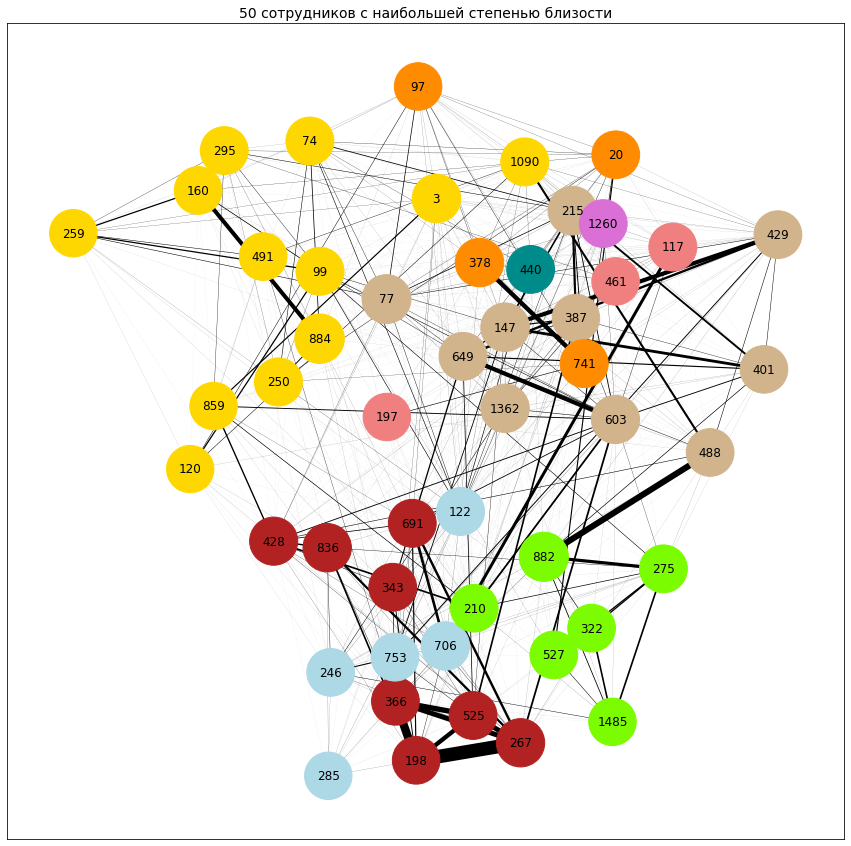

In [44]:
fig, ax = plt.subplots(figsize=(15,15))
subgraph=nx.subgraph(nx_graph, nbunch=most_reachable_list)
edge_width = [0.02 * nx_graph[u][v]['count'] for u, v in subgraph.edges()]
nx.draw_networkx(
    subgraph, ax=ax,
    node_size=closeness_rating.loc[list(subgraph.nodes)]['close_cent']*4e3,
    node_color=closeness_rating.loc[list(subgraph.nodes)]['dep_color'],
    pos=node_positions, width=edge_width
)
ax.set_title('50 сотрудников с наибольшей степенью близости', fontsize=14);

<div class='alert alert-block alert-warning'>
    <h4>В рейтингах по различным метрикам встречаются одни и те же сотрудники.</h4>
    <h4>Поэтому возникла идея составить некий обобщённый рейтинг "самых важных персон" - сотрудников с высокой влиятельностью и активностью.</h4>
    <h4>Информации о персоналиях у нас нет, можем лишь предполагать, что важные сотрудники - либо руководители подразделений, либо неформальные авторитеты в коллективе.</h4>
    <h4>Ну или просто очень общительные люди - распространители слухов, новостей и т.п.</h4>
</div>

In [45]:
vip_score = {'id': [], 'score': [], 'in_top_50': []}

for idx in user_summary_df.index:
    score = 868 - \
            activity_rating.index.tolist().index(idx) - \
            centrality_rating.index.tolist().index(idx) - \
            influence_rating.index.tolist().index(idx) - \
            closeness_rating.index.tolist().index(idx)
    if idx in most_active_list and \
        idx in most_important_list and \
        idx in most_influencing_list and \
        idx in most_reachable_list:
        in_top = 1
    else:
        in_top = 0
        
    vip_score['id'].append(idx)
    vip_score['score'].append(score)
    vip_score['in_top_50'].append(in_top)

In [46]:
vip_score_df = pd.DataFrame.from_dict(vip_score).set_index('id', drop=True).sort_index()
user_summary_df['vip_score'] = vip_score_df['score']
user_summary_df['in_top_50'] = vip_score['in_top_50']
vip_rating = user_summary_df.sort_values(by='vip_score', ascending=False)

In [47]:
vip_list = vip_rating.index.tolist()[:50]

In [48]:
user_summary_df

,cum_count,dep,dep_color,degree,betw_cent,eigenv_cent,close_cent,vip_score,in_top_50
id,,,,,,,,,
1,1.0,SFLE,lightcoral,1,0.000000,0.002169,0.365482,8,0
3,452.0,DMI,gold,68,0.006526,0.128571,0.590164,680,0
14,379.0,SCOM,orchid,40,0.004267,0.059715,0.546835,432,0
15,705.0,DMI,gold,50,0.005092,0.081743,0.551020,578,0
18,1143.0,SRH,yellow,48,0.006042,0.073846,0.555270,641,0
...,...,...,...,...,...,...,...,...,...
1362,477.0,DST,tan,66,0.007939,0.117956,0.585366,695,0
1392,1329.0,DST,tan,36,0.001976,0.063201,0.532020,473,0
1414,476.0,SFLE,lightcoral,37,0.001767,0.068578,0.535980,370,0


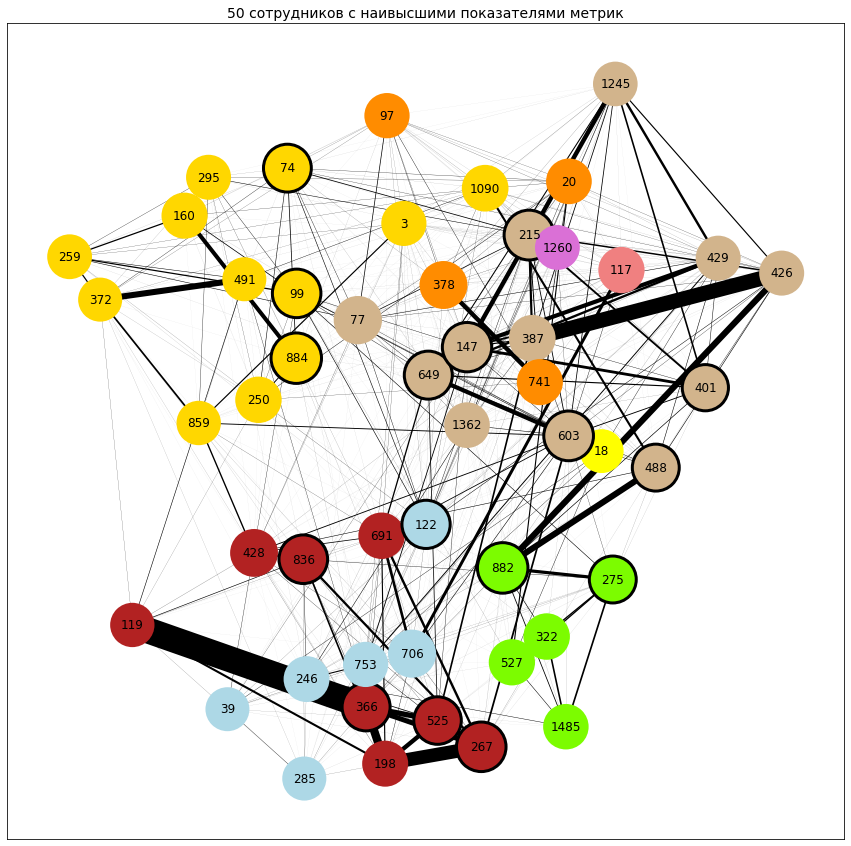

In [49]:
fig, ax = plt.subplots(figsize=(15,15))
subgraph=nx.subgraph(nx_graph, nbunch=vip_list)
edge_width = [0.02 * nx_graph[u][v]['count'] for u, v in subgraph.edges()]
nodes=nx.draw_networkx_nodes(
    subgraph, ax=ax,
    node_size=vip_rating.loc[list(subgraph.nodes)]['vip_score']*3,
    node_color=vip_rating.loc[list(subgraph.nodes)]['dep_color'],    
    pos=node_positions
)
nx.draw_networkx_edges(
    subgraph, ax=ax,
    pos=node_positions, width=edge_width
)
nx.draw_networkx_labels(
    subgraph, ax=ax,
    pos=node_positions
)
border_dict = {1: 'black', 0: 'white'}
nodes.set_edgecolor([border_dict[value] for value in vip_rating.loc[list(subgraph.nodes)]['in_top_50']])
nodes.set_linewidth([value*3 for value in vip_rating.loc[list(subgraph.nodes)]['in_top_50']])
ax.set_title('50 сотрудников с наивысшими показателями метрик', fontsize=14);

#### На иллюстрации выше чёрным обведены вершины сотрудников, которые вошли в топ 50 пользователей по всем метрикам.
#### Другими словами - это наши искомые "серые кардиналы", руководители, распространители слухов и просто любителю пообщаться.

## <a id='30'>3. Поиск циклов графа и клик</a>

#### Поиск различных форм сообществ в графе позволяет выделять обособленные группы сотрудников, анализировать однородность коллектива.

In [50]:
graph_cycles = nx.cycle_basis(nx_graph, 882)
cycle_lengths = [len(cycle) for cycle in graph_cycles]

In [51]:
pd.Series(cycle_lengths).describe()

count    4058.000000
mean        4.718088
std         3.012074
min         3.000000
25%         3.000000
50%         3.000000
75%         5.000000
max        26.000000
dtype: float64

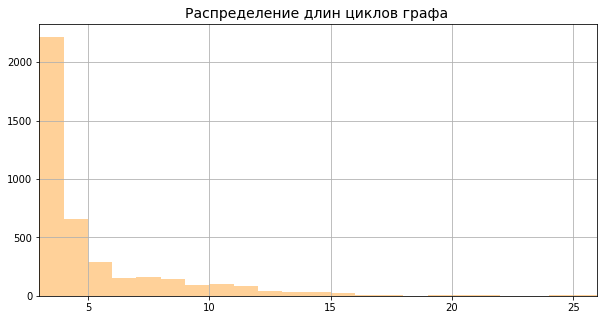

In [52]:
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(cycle_lengths, ax=ax, color='darkorange', kde=False, bins=23)
ax.grid()
ax.set_xlim(3, 26);
ax.set_title('Распределение длин циклов графа ', fontsize=14);

#### Преобладающая длина цикла в графе - 3.
#### Это означает, что практически все сотрудники, являются другу для друга если не знакомыми, то знакомыми знакомых.
#### С одной стороны, список сотрудников состоит из 217-ти человек. Это - не такой уж большой коллектив.
#### С другой стороны, id сотрудников принимает значения от 1 до 1492. Возможно, просто, не все приняли участие в исследовании.

In [53]:
longest_cycle_index = np.argmax(cycle_lengths)
longest_cycle_index

680

In [54]:
shortest_cycle_index = np.argmin(cycle_lengths)
shortest_cycle_index

0

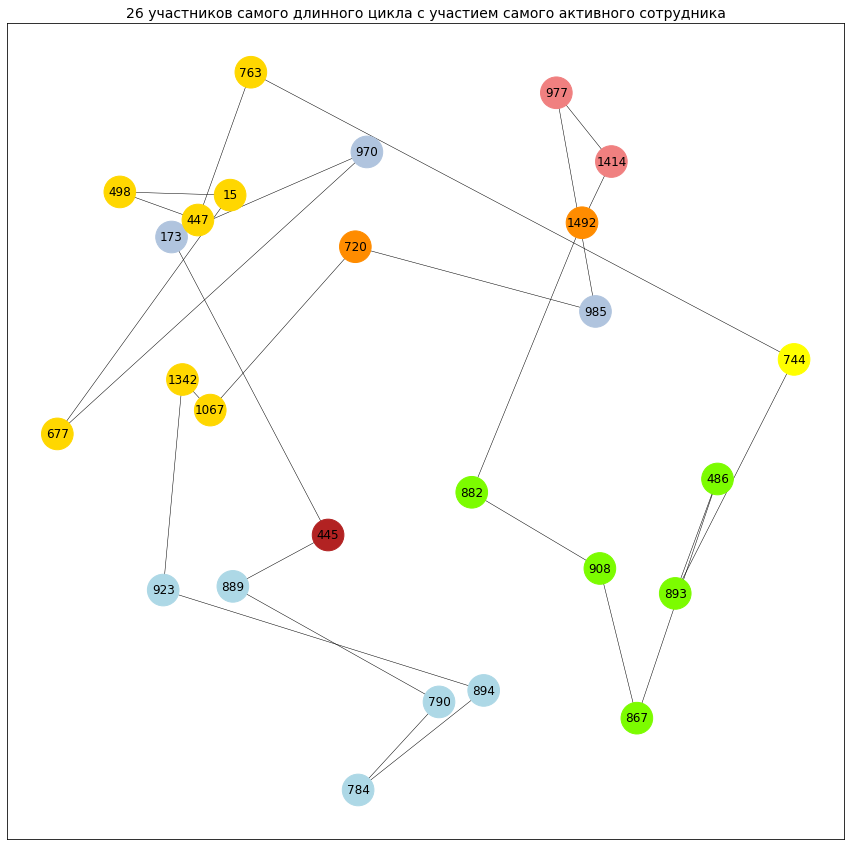

In [55]:
fig, ax = plt.subplots(figsize=(15,15))
subgraph=nx.subgraph(nx_graph, nbunch=graph_cycles[longest_cycle_index])
edge_width = [0.15 * nx_graph[u][v]['count'] for u, v in subgraph.edges()]
nx.draw_networkx(
    subgraph, ax=ax,
    node_size=1000,
    node_color=closeness_rating.loc[list(subgraph.nodes)]['dep_color'],
    pos=node_positions, width=0.5
)
ax.set_title('26 участников самого длинного цикла с участием самого активного сотрудника', fontsize=14);

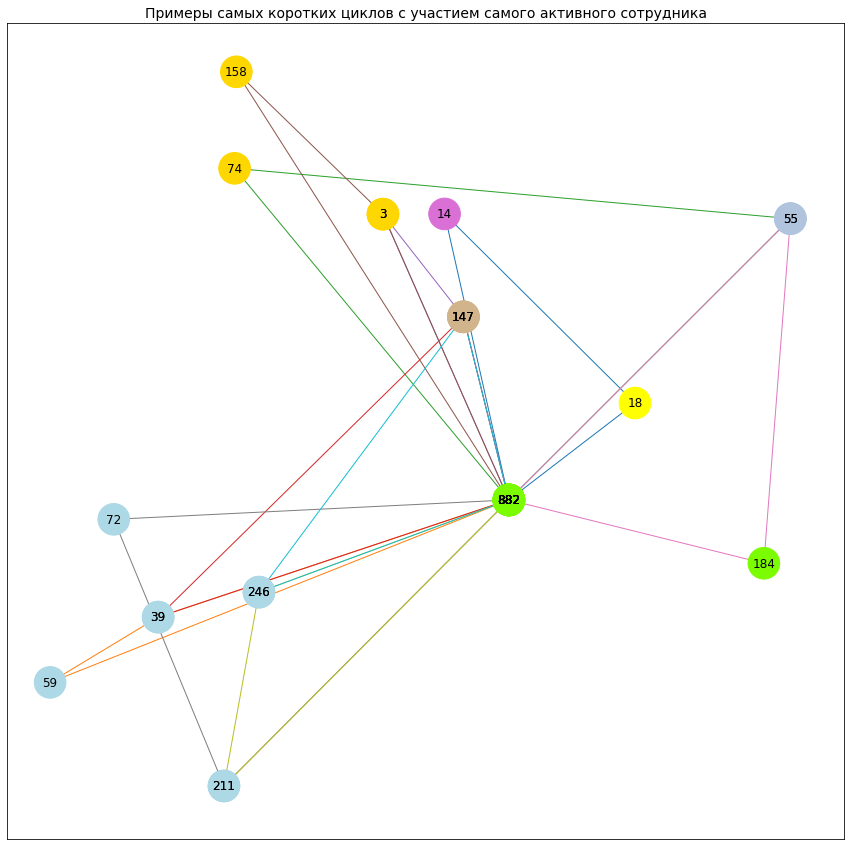

In [56]:
fig, ax = plt.subplots(figsize=(15,15))
max_cycles_to_draw = 10
cycles_count = 0
for cycle in graph_cycles[-1::-3]:
    if len(cycle)==3:
        subgraph=nx.subgraph(nx_graph, nbunch=cycle)        
        nx.draw_networkx(
            subgraph, ax=ax,
            node_size=1000,
            node_color=closeness_rating.loc[list(subgraph.nodes)]['dep_color'],
            pos=node_positions, width=1,
            edge_color = f'C{cycles_count}'
        )
    cycles_count += 1
    if cycles_count >= max_cycles_to_draw:
        break
ax.set_title('Примеры самых коротких циклов с участием самого активного сотрудника', fontsize=14);

In [57]:
graph_cliques = list(nx.find_cliques(nx_graph))

#### Клики - группы сотрудников, в которых любые два имеют связь.
#### Не имея информации о сотрудниках, интерес представляет лишь возможная принадлежность участников клик к одному и тому же департаменту.

In [58]:
clique_sizes = [len(clique) for clique in graph_cliques]

In [59]:
pd.Series(clique_sizes).describe()

count    6506.000000
mean        6.603750
std         2.214288
min         2.000000
25%         5.000000
50%         6.000000
75%         8.000000
max        15.000000
dtype: float64

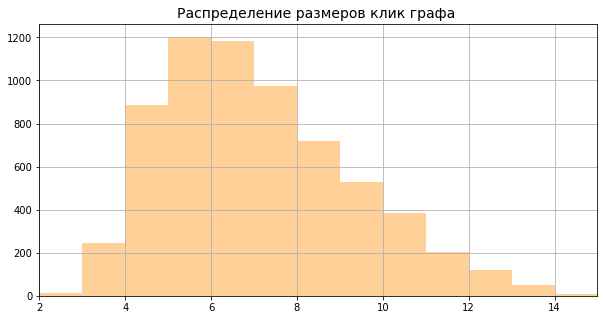

In [60]:
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(clique_sizes, ax=ax, color='darkorange', kde=False, bins=13)
ax.grid()
ax.set_xlim(2, 15);
ax.set_title('Распределение размеров клик графа ', fontsize=14);

#### Преобладающий размер клик в 5-6 сотрудников может соответствовать размеру небольших подразделений - проектных групп, отделов.

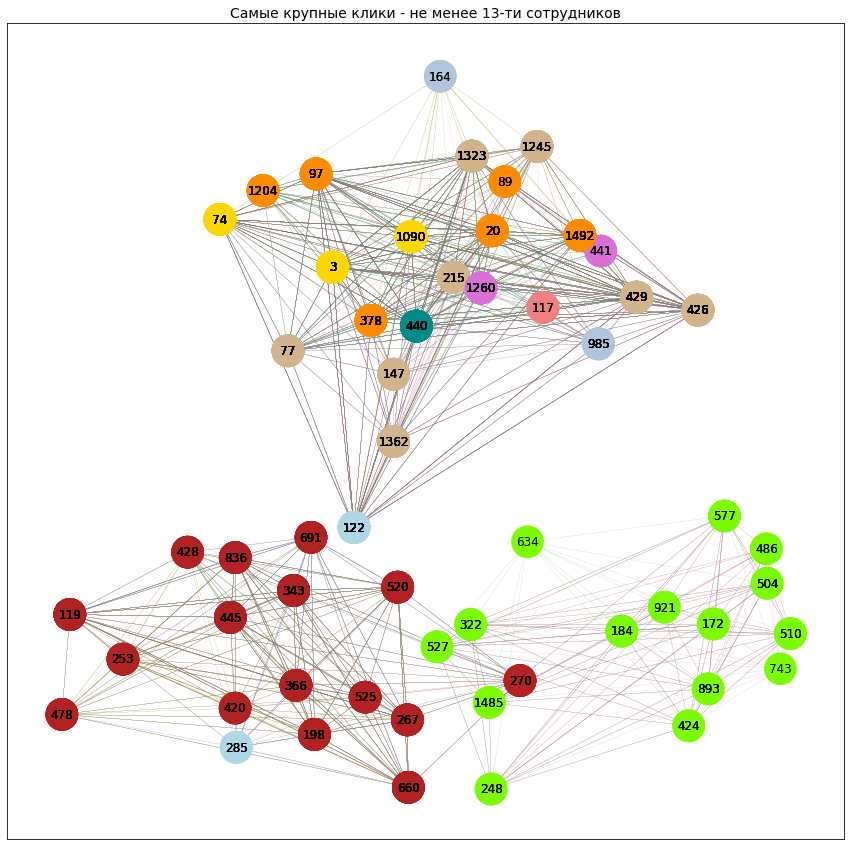

In [61]:
fig, ax = plt.subplots(figsize=(15,15))
max_cliques_to_draw = 40
cliques_count = 0
for clique in graph_cliques:
    if len(clique)>=13:
        subgraph=nx.subgraph(nx_graph, nbunch=clique)        
        nx.draw_networkx(
            subgraph, ax=ax,
            node_size=1000,
            node_color=user_summary_df.loc[list(subgraph.nodes)]['dep_color'],
            pos=node_positions, width=0.1,
            edge_color = f'C{cliques_count}'
        )
        cliques_count += 1
    if cliques_count >= max_cliques_to_draw:
        break
ax.set_title('Самые крупные клики - не менее 13-ти сотрудников', fontsize=14);

<div class='alert alert-block alert-warning'>
    <h4>Самые крупные клики по 13-15 сотрудников составлены, преимущественно, из сотрудников одного-двух департаментов.</h4>
    <h4>Можно также отметить участие в кликах тёмно-красного и зелёного цветов по одному сотруднику из другого департамента.</h4>
    <h4>Предположительно - это руководители, общающиеся с сотрудниками смежных депаратментов, либо сотрудники, перешедшие из одного департамента в другой, продолжающие общаться с бывшими коллегами.</h4>
</div>